In [1]:
from keras.models import Model
from keras.layers import Input, Dense
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.optimizers import Adam
import matplotlib.pyplot as plt

from keras.layers import Conv2D, Conv2DTranspose, Flatten, MaxPooling2D, UpSampling2D, Reshape



In [67]:
"""
-- Load data from analysis dataset --
"""

parent_folder_path = "images/resized_dataset/"

categories = {}

# Iterate over the contents of the "original_dataset" folder
for index, folder_name in enumerate(sorted(os.listdir(parent_folder_path))):
    folder_path = os.path.join(parent_folder_path, folder_name)
    if os.path.isdir(folder_path):
        categories[folder_name] = index

category_amount = []

# get the category with the least images
for category in categories.keys():
    folder_path = os.path.join(parent_folder_path, category)
    image_files = os.listdir(folder_path)
    category_amount.append(len(image_files))


arrays = []
# convert the images into a pytorch dataset
for cat_folder, value in categories.items():

    folder_path = os.path.join(parent_folder_path, cat_folder)
    image_files = os.listdir(folder_path)

    for i, file_name in enumerate(image_files):

        file_path = os.path.join(folder_path, file_name)
        image = Image.open(file_path)
        image_array = np.array(image)

        # verify all images are of the desired size
        if image.size != (64, 64):
            print(file_path, " IS NOT 250x250, it is: ", image.size)
            continue

        #if image_array.shape != (64, 64):
            #image_array = np.dot(image_array[..., :3], [0.2989, 0.5870, 0.1140])

        arrays.append(image_array)

# Normalize the array of the normal 
#arrays = np.array(arrays).astype('float32') / 255

arrays_labels = []
for i in range(len(categories)):
    arrays_labels += [i] * category_amount[i]




In [68]:
"""
-- Load autoencoder, train and testing data --

Using the distribution:
80% -> autoencoder
10% -> training data
10% -> testing data
"""
arrays_labels = np.array(arrays_labels)

X_auto, X, y_auto, y = train_test_split(arrays, arrays_labels, test_size=0.5, random_state=42, stratify=arrays_labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)



#X_auto = np.array(X_auto)
X_auto = np.array(X_auto).astype('float32') / 255
X_auto = X_auto.reshape((len(X_auto), -1))

#X_train = np.array(X_train)
X_train = np.array(X_train).astype('float32') / 255
X_train = X_train.reshape((len(X_train), -1))

#X_test = np.array(X_test)
X_test = np.array(X_test).astype('float32') / 255
X_test = X_test.reshape((len(X_test), -1))

y_train = to_categorical(y_train, num_classes=38)
y_test = to_categorical(y_test, num_classes=38)

#X = np.array(X)
#X = X.reshape((len(X), -1))


In [80]:
"""
With MLP
"""

# definir la arquitectura del autoencoder

input_img = Input(shape=(12288,))
encoded = Dense(32, activation='relu')(input_img)
latent = Dense(16, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(latent)
decoded = Dense(12288, activation='sigmoid')(decoded)

# Crear el modelo del autoencoder
autoencoder = Model(input_img, decoded)

# Compilar el modelo
optimizer = Adam(learning_rate = 0.07)
autoencoder.compile(optimizer=optimizer, loss='MSE', metrics=['accuracy'])

print("Before fit autoencoder")

# Entrenar el autoencoder
autoencoder.fit(X_auto, X_auto,
                epochs=10,
                batch_size=256,
                shuffle=True)

print("after autoencoder")
# Obtener el vector latente (representación codificada)
encoder = Model(input_img, latent)
encoded_train = encoder.predict(X_train)
encoded_test = encoder.predict(X_test)



Before fit autoencoder
Epoch 1/10
107/107 [==============================] - 7s 59ms/step - loss: 0.2159 - accuracy: 4.4196e-04
Epoch 2/10
107/107 [==============================] - 5s 51ms/step - loss: 0.2180 - accuracy: 4.4196e-04
Epoch 3/10
107/107 [==============================] - 5s 51ms/step - loss: 0.2180 - accuracy: 4.4196e-04
Epoch 4/10
107/107 [==============================] - 5s 50ms/step - loss: 0.2180 - accuracy: 4.4196e-04
Epoch 5/10
107/107 [==============================] - 5s 47ms/step - loss: 0.2180 - accuracy: 4.4196e-04
Epoch 6/10
107/107 [==============================] - 5s 47ms/step - loss: 0.2180 - accuracy: 4.4196e-04
Epoch 7/10
107/107 [==============================] - 5s 48ms/step - loss: 0.2180 - accuracy: 4.4196e-04
Epoch 8/10
107/107 [==============================] - 5s 50ms/step - loss: 0.2180 - accuracy: 4.4196e-04
Epoch 9/10
107/107 [==============================] - 5s 49ms/step - loss: 0.2180 - accuracy: 4.4196e-04
Epoch 10/10
107/107 [===========

In [83]:
"""
With CNN
"""

X_auto = X_auto.reshape((len(X_auto), 64, 64, 3))
X_train = X_train.reshape((len(X_train), 64, 64, 3))

X_test = X_test.reshape((len(X_test), 64, 64, 3))

# definir la arquitectura del autoencoder

input_img = Input(shape=X_auto[0].shape)
encoded = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
latent = MaxPooling2D((2, 2), padding='same')(encoded)
decoded = Conv2D(16, (3, 3), activation='relu', padding='same')(latent)
decoded = UpSampling2D((2,2))(decoded)
decoded = Conv2D(3, (3, 3), activation='relu', padding='same')(decoded)

# Crear el modelo del autoencoder
autoencoder = Model(input_img, decoded)

# Compilar el modelo
optimizer = Adam(learning_rate = 0.01)
autoencoder.compile(optimizer=optimizer, loss='MSE', metrics=['accuracy'])

print("Before fit autoencoder")

# Entrenar el autoencoder
autoencoder.fit(X_auto, X_auto,
                epochs=10,
                batch_size=256,
                shuffle=True)

print("after autoencoder")
# Obtener el vector latente (representación codificada)
encoder = Model(input_img, latent)
encoded_train = encoder.predict(X_train)
encoded_test = encoder.predict(X_test)

Before fit autoencoder
Epoch 1/10
107/107 [==============================] - 73s 674ms/step - loss: 0.0142 - accuracy: 0.8067
Epoch 2/10
107/107 [==============================] - 73s 684ms/step - loss: 0.0030 - accuracy: 0.9123
Epoch 3/10
107/107 [==============================] - 73s 686ms/step - loss: 0.0023 - accuracy: 0.9440
Epoch 4/10
107/107 [==============================] - 71s 666ms/step - loss: 0.0021 - accuracy: 0.9528
Epoch 5/10
107/107 [==============================] - 70s 658ms/step - loss: 0.0019 - accuracy: 0.9582
Epoch 6/10
107/107 [==============================] - 72s 671ms/step - loss: 0.0018 - accuracy: 0.9618
Epoch 7/10
107/107 [==============================] - 73s 683ms/step - loss: 0.0017 - accuracy: 0.9645
Epoch 8/10
107/107 [==============================] - 74s 689ms/step - loss: 0.0016 - accuracy: 0.9663
Epoch 9/10
107/107 [==============================] - 70s 658ms/step - loss: 0.0016 - accuracy: 0.9675
Epoch 10/10
107/107 [=============================

128/128 [==============================] - 3s 20ms/step


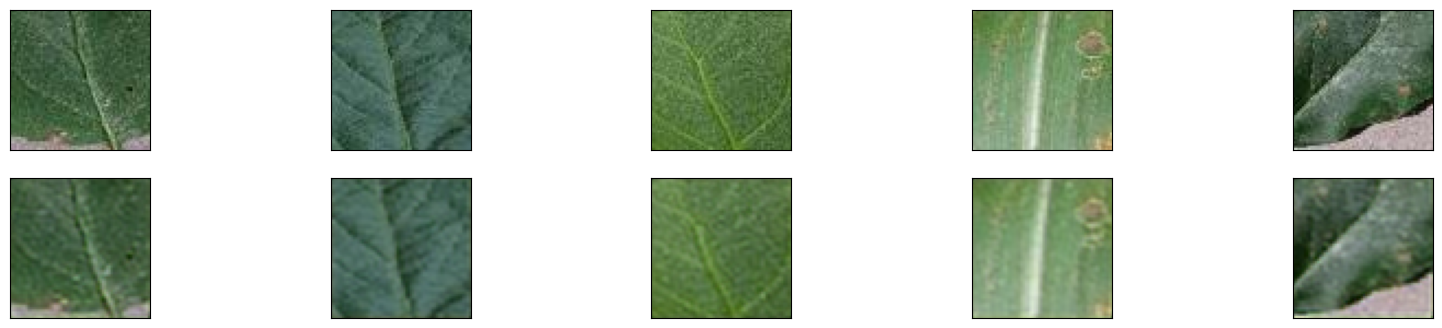

In [84]:
reconstructed_imgs = autoencoder.predict(X_test)

n = 5  # número de imágenes a mostrar
plt.figure(figsize=(20, 4))
for i in range(n):
    # Imagen original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagen reconstruida
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_imgs[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [98]:
# Definir la arquitectura del clasificador utilizando el vector latente como entrada
input_latent = Input(shape=encoded_train[0].shape)
output = Flatten()(input_latent)
#output = Dense(64, activation='relu')(output)
output = Dense(38, activation='sigmoid')(output)

# Crear el modelo del clasificador
classifier = Model(input_latent, output)

# Compilar el modelo del clasificador
optimizer = Adam(learning_rate = 0.0005)
classifier.compile(optimizer=optimizer, loss='MSE', metrics=['accuracy'])

# Entrenar el clasificador utilizando el vector latente como características de entrada
classifier.fit(encoded_train, y_train,
               epochs=100,
               batch_size=128,
               validation_data=(encoded_test, y_test), verbose=1)

# Evaluar el rendimiento del clasificador en el conjunto de prueba
loss, accuracy = classifier.evaluate(encoded_test, y_test)
print("Pérdida de clasificación:", loss)
print("Exactitud de clasificación:", accuracy)

Epoch 1/100
181/181 [==============================] - 7s 30ms/step - loss: 0.0271 - accuracy: 0.1682 - val_loss: 0.0237 - val_accuracy: 0.2413
Epoch 2/100
181/181 [==============================] - 6s 32ms/step - loss: 0.0235 - accuracy: 0.2387 - val_loss: 0.0233 - val_accuracy: 0.2480
Epoch 3/100
181/181 [==============================] - 6s 34ms/step - loss: 0.0232 - accuracy: 0.2435 - val_loss: 0.0230 - val_accuracy: 0.2512
Epoch 4/100
181/181 [==============================] - 6s 34ms/step - loss: 0.0229 - accuracy: 0.2546 - val_loss: 0.0227 - val_accuracy: 0.2654
Epoch 5/100
181/181 [==============================] - 6s 34ms/step - loss: 0.0225 - accuracy: 0.2731 - val_loss: 0.0225 - val_accuracy: 0.2740
Epoch 6/100
181/181 [==============================] - 6s 33ms/step - loss: 0.0223 - accuracy: 0.2830 - val_loss: 0.0223 - val_accuracy: 0.2821
Epoch 7/100
181/181 [==============================] - 6s 34ms/step - loss: 0.0221 - accuracy: 0.2907 - val_loss: 0.0222 - val_accuracy: